In [5]:
import numpy as np
import time
from tqdm import tqdm

import torch.nn as nn
import torch
import os

In [6]:
import cv2 as cv
import matplotlib.pyplot as plt

from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

## Discriminator Block

In [7]:
class Discriminator_Conv(nn.Module):

    def __init__(self, channels, normalization, kernel = 3, stride = 2, padding = 1, activation = nn.LeakyReLU(0.2, True), is_bias = False):
        super(Discriminator_Conv, self).__init__()

        # Now initializing all the all variables
        self.channel = channels
        self.kernel = kernel
        self.padding = padding
        self.stride = stride
        self.is_bias = is_bias
        # self.normalization = normalization
        # self.activation = activation

        # now making the conv block

        self.conv_layer = nn.Sequential(
            nn.Conv2d(self.channel, self.channel, self.kernel, self.stride, self.padding, bias = is_bias),
            activation,
            nn.Conv2d(self.channel, self.channel*2, self.kernel, 1, padding = 'same', bias = is_bias),
            normalization,
            activation,
        )
    
    def forward(self,img):
        out_img = self.conv_layer(img)
        return out_img

## Discriminator Model

In [9]:
class Discriminator(nn.Module):

    def __init__(self, args = {'name' : 'discriminator1', 'bias' : False, 'n_blocks' : 7, 'initial_channels' : 32, 'size' : (256,256),} ):
        super(Discriminator, self).__init__()

        # initializing the parameters
        self.name = args['name']
        self.bias = args['bias']

        # n_blocks
        self.n_blocks = args['n_blocks']

        # initializing the initial channels
        self.initial_channels = args['initial_channels']

        # initial size
        self.h,self.w = args['size']
        h,w = self.h,self.w

        # now initializing the initial layer
        self.initial_conv_layer = nn.Sequential(
            nn.Conv2d(3, self.initial_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.2, True)
        )

        print(f"Warning : Please Try to give image of size as power to two, in-order to avoid any dimensionality errors")

        intermediate_layers = []
        channels = self.initial_channels

        # defining the conv blocks
        for i in range(self.n_blocks):

            # getting the image dim
            c,h,w = channels*2,h//2,w//2

            # just defining a yet another type of normalization to experiment with
            # nn.InstanceNorm2d(c)
            # nn.LayerNorm([c,h,w])
            # nn.GroupNorm(1,c) # -> equivalent to layer Norm without element-wise affine

            # defining the block
            block = Discriminator_Conv(channels = channels, normalization = nn.GroupNorm(1,c), kernel = 3, stride = 2, padding = 1, activation = nn.LeakyReLU(0.2, True), is_bias = self.bias)

            # appending the block
            intermediate_layers.append(block)

            # updating the channels
            channels = channels*2
        
        self.intermediate_conv_layer = nn.Sequential(*intermediate_layers)

        # getting the channels and image size after coming out of the loop
        c,h,w = channels,h,w

        # Now making the final conv layer to classify the output
        self.out_conv_layer = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1, bias = self.bias),
            nn.GroupNorm(1,c),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(channels, 1, 3, 1, 1, bias = True),
        )
    
    # Now we have defined all layers

    def forward(self,img):

        out_img = self.initial_conv_layer(img)
        out_img = self.intermediate_conv_layer(out_img)
        out_img = self.out_conv_layer(out_img)

        return out_img

## Testing the Discriminator model

In [10]:
# d_args = {'name' : 'discriminator1', 'bias' : False, 'n_blocks' : 3, 'initial_channels' : 32, 'size' : (256,256),}
# d_model = Discriminator(args = d_args,).to(device)

In [11]:
# printing the model
# d_model

Discriminator(
  (initial_conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (intermediate_conv_layer): Sequential(
    (0): Discriminator_Conv(
      (conv_layer): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (3): GroupNorm(1, 64, eps=1e-05, affine=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (1): Discriminator_Conv(
      (conv_layer): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
        (3): GroupNorm(1, 128, eps=1e-05, affine=True)


In [12]:
# # printing total learnable weights in the model 
# print(f"Total Learnable weights in the model is : {sum([p.numel() for p in d_model.parameters() if p.requires_grad])*1e-6:.3f}M")

Total Learnable weights in the model is : 1.175M


In [15]:
# for p in d_model.parameters():
#     print(p.numel(),' - ',p.shape)

864  -  torch.Size([32, 3, 3, 3])
32  -  torch.Size([32])
9216  -  torch.Size([32, 32, 3, 3])
18432  -  torch.Size([64, 32, 3, 3])
64  -  torch.Size([64])
64  -  torch.Size([64])
36864  -  torch.Size([64, 64, 3, 3])
73728  -  torch.Size([128, 64, 3, 3])
128  -  torch.Size([128])
128  -  torch.Size([128])
147456  -  torch.Size([128, 128, 3, 3])
294912  -  torch.Size([256, 128, 3, 3])
256  -  torch.Size([256])
256  -  torch.Size([256])
589824  -  torch.Size([256, 256, 3, 3])
256  -  torch.Size([256])
256  -  torch.Size([256])
2304  -  torch.Size([1, 256, 3, 3])
1  -  torch.Size([1])


Shape of the image is : torch.Size([3, 256, 256])
Shape of the output image is : torch.Size([1, 32, 32])


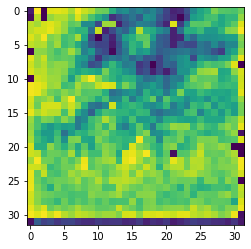

In [64]:
# ### Testing the model by passing a image

# transformations = transforms.Compose([
#     transforms.Resize((256,256)),
#     transforms.ToTensor(),
#     ])

# img = transformations( Image.open('../../All Content Image/animals/b-1.jpg').convert('RGB') )
# print(f"Shape of the image is : {img.shape}")
# out_img = d_model(img.to(device))
# print(f"Shape of the output image is : {out_img.shape}")

# out_img = transforms.ToPILImage()(out_img)
# plt.imshow(out_img)